In [1]:
import numpy as np
import pandas as pd
import nltk

In [85]:
def get_paragraph_embedding(paragraph, embeddings, embedding_size=0,
                            ignore_unknown=True,
                            unknown_embedding=None):
    '''Return a paragraph embedding as an average of its word embeddings.'''
    embedding_size = embeddings['the'].shape[0]
    paragraph_embedding = np.zeros(embedding_size)
    count_words = 0
    for word in paragraph:
        if word in embeddings:
            we = embeddings[word]
            paragraph_embedding += we
            count_words += 1
        elif not ignore_unknown:
            we = unknown_embedding
            paragraph_embedding += we
            count_words += 1
    if count_words == 0:
        paragraph_embedding = paragraph_embedding
    else:
        paragraph_embedding = paragraph_embedding / count_words
    return paragraph_embedding

In [3]:
def calculate_similarity(paragraph_embedding, question_embedding):
    similarity = np.dot(paragraph_embedding, question_embedding)
    return similarity

In [4]:
def load_embeddings(filepath):
    embeddings = {}
    with open(filepath, "rb") as f:
        for line in f:
            line = line.decode("utf-8")
            elements = line.strip().split(' ', 1)
            word = elements[0]
            vector = [float(x) for x in elements[1].split(' ')]
            vector = np.array(vector)
            embeddings[word] = vector
    return embeddings

In [5]:
embedding_size = 50
embeddings = load_embeddings("../glove.6B.50d.txt")

In [8]:
embeddings['quick']

array([ 0.13967  , -0.53798  , -0.18047  , -0.25142  ,  0.16203  ,
       -0.13868  , -0.24637  ,  0.75111  ,  0.27264  ,  0.61035  ,
       -0.82548  ,  0.038647 , -0.32361  ,  0.30373  , -0.14598  ,
       -0.23551  ,  0.39267  , -1.1287   , -0.23636  , -1.0629   ,
        0.046277 ,  0.29143  , -0.25819  , -0.094902 ,  0.79478  ,
       -1.2095   , -0.01039  , -0.092086 ,  0.84322  , -0.11061  ,
        3.0096   ,  0.51652  , -0.76986  ,  0.51074  ,  0.37508  ,
        0.12156  ,  0.082794 ,  0.43605  , -0.1584   , -0.61048  ,
        0.35006  ,  0.52465  , -0.51747  ,  0.0034705,  0.73625  ,
        0.16252  ,  0.85279  ,  0.85268  ,  0.57892  ,  0.64483  ])

In [23]:
train_data = pd.read_csv("../data/train.csv", encoding='utf-8')

In [24]:
train_data = train_data.dropna()

In [25]:
train_data[:5]

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [26]:
question1 = list(train_data["question1"])

In [27]:
question2 = list(train_data["question2"])

In [28]:
is_duplicate = list(train_data["is_duplicate"])

In [29]:
len(question1), len(question2)

(404288, 404288)

In [30]:
def remove_weird_chars(q):
    return q.encode('ascii', 'ignore')
q1_sent_tokenized = [nltk.sent_tokenize(remove_weird_chars(q1)) for q1 in question1]

In [31]:
q2_sent_tokenized = [nltk.sent_tokenize(remove_weird_chars(q2)) for q2 in question2]

In [32]:
q1_word_tokenized = []
for q1_sent in q1_sent_tokenized:
    S = []
    for s in q1_sent:
        S.extend(nltk.word_tokenize(s))
    q1_word_tokenized.append(S)

In [33]:
q2_word_tokenized = []
for q2_sent in q2_sent_tokenized:
    S = []
    for s in q2_sent:
        S.extend(nltk.word_tokenize(s))
    q2_word_tokenized.append(S)

In [38]:
print(q2_word_tokenized[40])
print(q1_word_tokenized[40])

['Will', 'squats', 'make', 'my', 'legs', 'thicker', '?']
['Why', 'do', 'Slavs', 'squat', '?']


In [39]:
print(is_duplicate[:10])

[0, 0, 0, 0, 0, 1, 0, 1, 0, 0]


In [37]:
len(q1_word_tokenized), len(q2_word_tokenized), len(is_duplicate)

(404288, 404288, 404288)

I AM HERE

In [45]:
# Save these files so I don't have to do this again
import csv
def save_tokenized(words_tokenized, path):
    with open(path, 'w') as f:
        writer = csv.writer(f, delimiter='|')
        for line in words_tokenized:
            l_in_glove = [(w.lower() if w.lower() in embeddings else '<unk>') for w in line]
            writer.writerow(l_in_glove)

save_tokenized(q1_word_tokenized, '../data/train_q1.txt')
save_tokenized(q2_word_tokenized, '../data/train_q2.txt')

In [47]:
# Save the labels as well.
with open('../data/train_is_duplicate.txt', 'w') as f:
    for is_dup in is_duplicate:
        f.write(str(is_dup))
        f.write('\n')

In [48]:
q1_embeddings = []
for q1 in q1_word_tokenized:
    e = get_paragraph_embedding(q1, embeddings, embedding_size, ignore_unknown=True)
    q1_embeddings.append(e)

In [49]:
q2_embeddings = []
for q2 in q2_word_tokenized:
    e = get_paragraph_embedding(q2, embeddings, embedding_size, ignore_unknown=True)
    q2_embeddings.append(e)

In [50]:
q1_embeddings[:3]

[array([ 0.35366419,  0.03833964,  0.01953536,  0.06931   ,  0.38226814,
        -0.05137364, -0.36991901, -0.29983486, -0.0116763 ,  0.08655371,
         0.05764364,  0.07743236, -0.33866921, -0.18898182,  0.26450716,
         0.39870071,  0.16967421, -0.00728307, -0.25885138, -0.18244971,
         0.48905493, -0.00527301, -0.00482579, -0.01139729,  0.1307275 ,
        -1.57990714, -0.27115071, -0.17342526,  0.03555186, -0.030406  ,
         3.39192143,  0.19942143, -0.26855257, -0.09582714,  0.04574472,
        -0.37669044, -0.17840407,  0.15865429, -0.01094743, -0.21468236,
        -0.272817  , -0.05851231,  0.10177307, -0.07771479, -0.07253807,
         0.20498281, -0.12513408,  0.06108879,  0.15669007, -0.05609071]),
 array([  2.21262857e-01,   6.99364286e-01,  -1.67583571e-01,
          9.92642857e-02,   4.29764071e-01,   2.84206143e-01,
         -3.46837286e-02,  -7.06412857e-01,  -2.70095747e-01,
         -2.67267571e-01,  -1.54111429e-02,   2.59952857e-01,
         -2.91469257

In [65]:
def cosine_dist(q1_embed, q2_embed):
    similarity = np.dot(q1_embed, q2_embed)
    q1_len = np.sqrt(np.dot(q1_embed, q1_embed)) + 1e-4
    q2_len = np.sqrt(np.dot(q2_embed, q2_embed)) + 1e-4
    return similarity / q1_len / q2_len
similarity = [cosine_dist(q1, q2) for q1, q2 in zip(q1_embeddings, q2_embeddings)]

In [73]:
data = [(s, d) for s, d in zip(similarity, is_duplicate)]
sim_array = np.array(similarity)
print(sim_array.shape)
dat_array = np.array(is_duplicate)
print(dat_array.shape)

(404288,)
(404288,)


In [67]:
len(similarity), len(data)

(404288, 404288)

In [68]:
data[:3]

[(0.9946319280636694, 0), (0.92681689248468313, 0), (0.97470912044718716, 0)]

In [79]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(dat_array, sim_array)
auc = roc_auc_score(dat_array, sim_array)

print('AUC: {0}'.format(auc))

AUC: 0.659087492549


In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.dpi'] = 100

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

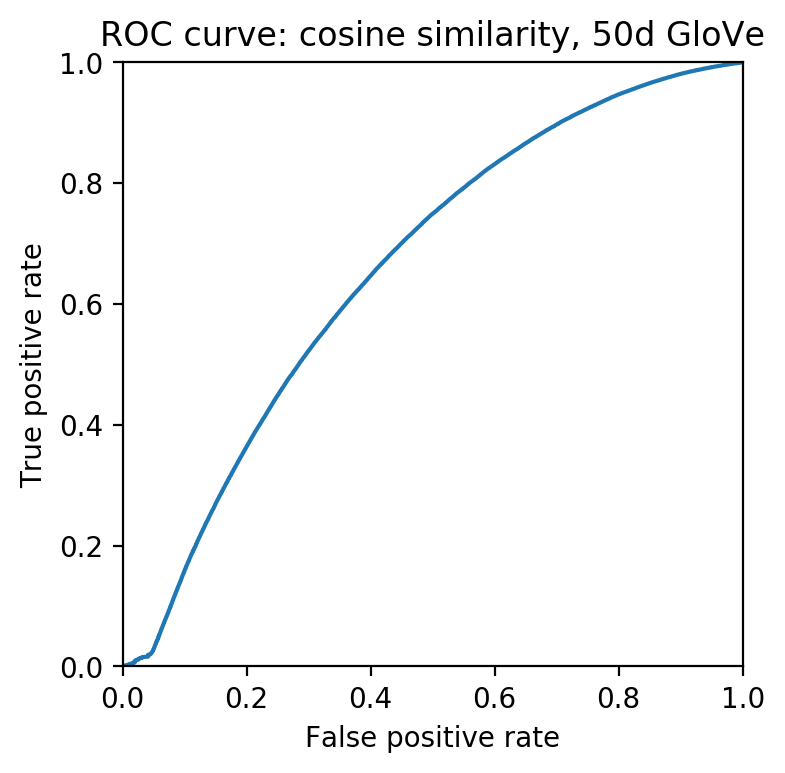

In [84]:
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr)
plt.title('ROC curve: cosine similarity, 50d GloVe')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [86]:
# What about 300d GloVe?
embeddings300 = load_embeddings("../data/glove.6B.300d.txt")

In [87]:
del q1_embeddings
del q2_embeddings
del data
del embeddings

In [90]:
q1_emb300 = []
q2_emb300 = []
for q1 in q1_word_tokenized:
    e = get_paragraph_embedding(q1, embeddings300, embedding_size, ignore_unknown=True)
    q1_emb300.append(e)
for q2 in q2_word_tokenized:
    e = get_paragraph_embedding(q2, embeddings300, embedding_size, ignore_unknown=True)
    q2_emb300.append(e)

In [91]:
# Sanity check
print(q1_emb300[24].shape)
print(q2_emb300[72].shape)

(300,)
(300,)


In [92]:
sim300 = [cosine_dist(q1, q2) for q1, q2 in zip(q1_emb300, q2_emb300)]

(404288,)
(404288,)
AUC: 0.67116907076


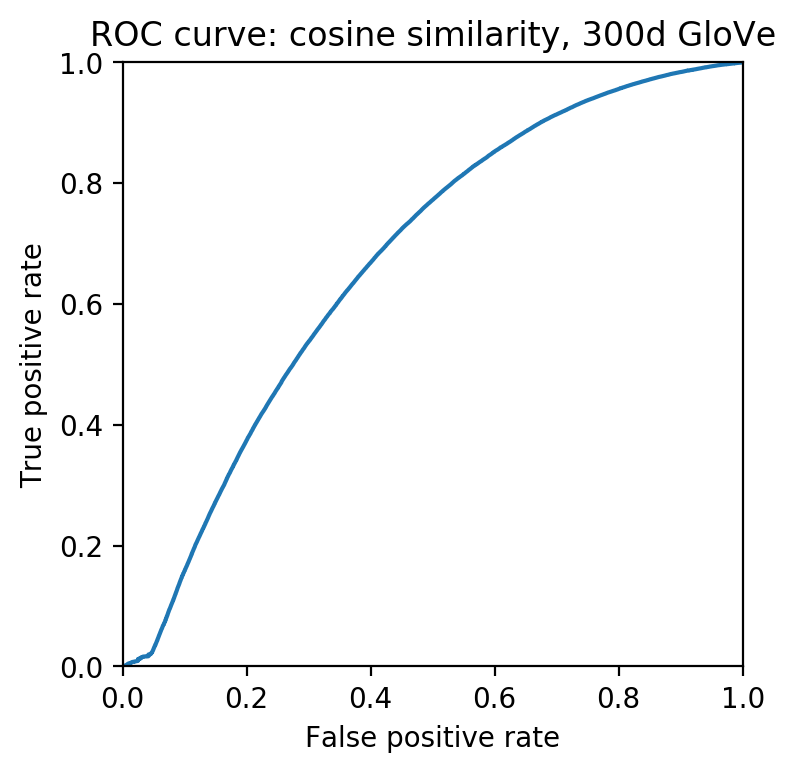

In [97]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(dat_array, sim_array)
auc = roc_auc_score(dat_array, sim_array)

print('AUC: {0}'.format(auc))

# Evaluate.
def evaluate(similarity, title):
    sim_array = np.array(similarity)
    print(sim_array.shape)
    dat_array = np.array(is_duplicate)
    print(dat_array.shape)

    fpr, tpr, thresholds = roc_curve(dat_array, sim_array)
    auc = roc_auc_score(dat_array, sim_array)

    print('AUC: {0}'.format(auc))

    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr)
    plt.title('ROC curve: ' + title)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()
evaluate(sim300, 'cosine similarity, 300d GloVe')

Going from 50d to 300d didn't add much in the end. What about if I use a SVM on the embeddings?

In [99]:
q1_array, q2_array = np.array(q1_emb300), np.array(q2_emb300)

In [106]:
del X

In [107]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

rand = 33

X = np.concatenate([q1_array, q2_array], axis=1)
y = is_duplicate
print(X.shape)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=rand)

nrm = Normalizer()
X_train = nrm.fit_transform(X_train)
X_valid = nrm.transform(X_valid)

(404288, 600)


MemoryError: 

I didn't run the rest.

In [54]:
data.sort(key=lambda x: x[0])

In [55]:
prev_sum = 0
duplicate_history = []

for d in data:
    prev_sum += d[1]
    duplicate_history.append(prev_sum)

In [56]:
len(data)

404288

In [57]:
actual_originals = is_duplicate.count(0)

In [58]:
actual_duplicates = is_duplicate.count(1)

In [59]:
accuracies = []

for i in range(len(data)):
    correct_original = i + 1 - duplicate_history[i]
    correct_duplicates = actual_duplicates - duplicate_history[i]
    acc = (correct_original + correct_duplicates) / len(data)
    accuracies.append((i, acc))

In [60]:
accuracies.sort(key=lambda x: x[1])

In [61]:
accuracies[-10:]

[(404278, 0),
 (404279, 0),
 (404280, 0),
 (404281, 0),
 (404282, 0),
 (404283, 0),
 (404284, 0),
 (404285, 0),
 (404286, 0),
 (404287, 0)]

In [103]:
mx = max(similarity)
mn = min(similarity)

In [104]:
print(mx, mn)

32.7865704148 -4.98850421349


In [110]:
shifted_similarity = [s - mn for s in similarity]

In [112]:
mx2 = max(shifted_similarity)

In [113]:
mx2

37.775074628331403

In [114]:
scaled_shifted_similarity = [x / mx2 for x in shifted_similarity]